This script replicates the experiments in the original orthogonal learning paper.

In [1]:
import os
from joblib import Parallel, delayed
import argparse
import numpy as np
import joblib
from econml.dr import DRLearner
from sklearn.model_selection import train_test_split
from econml.dml import NonParamDML
import warnings
warnings.simplefilter('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# DGP
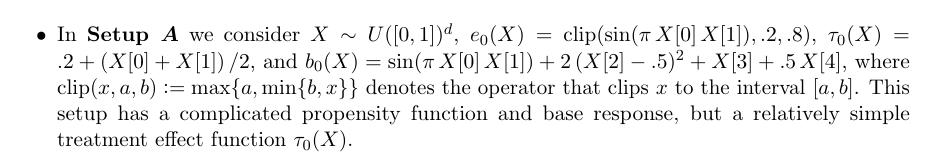

In [2]:
#here we replicate steup A, sigma is the standard deviation of the noise
def gen_data(n,d, base_fn, tau_fn, prop_fn, sigma):
    X = np.random.uniform(0,1, size = (n,d))
    X_test = np.random.uniform(0,1, size = (10000, d))
    T = np.random.binomial(1, prop_fn(X)) #here, 1 refers to number of trials, 1 reduces the binomial distribution to a bernoulli distribution
    y = (T - .5)*tau_fn(X) + base_fn(X) + sigma*np.random.normal(0,1, size = (n,))
    return y, T, X, X_test

def get_data_generator(n, d, sigma):
        def base_fn(X): return np.sin(np.pi * X[:, 0] * X[:, 1]) + 2*(X[:, 2] - .5)**2 + X[:, 3] + .5*X[:, 4]
        def prop_fn(X): return np.clip(
            np.sin(np.pi * X[:, 0] * X[:, 1]), .2, .8)
        def tau_fn(X): return .2 + (X[:, 0] + X[:, 1]) / 2
        def gen_data_fn(): return gen_data(
            n, d, base_fn, tau_fn, prop_fn, sigma)
        return gen_data_fn, base_fn, tau_fn, prop_fn

In [3]:
def rmse(ytrue, y):
    return np.sqrt(np.mean((ytrue.flatten() - y.flatten())**2))
    
def exp(y, T, X, Xtest, method_list, tau_fn, n_x):
    results = {}
    for name, method in method_list:
        print(name)
        tau_est, est = method(y, T, X, Xtest, n_x)
        results[name] = rmse(tau_fn(Xtest), tau_est)**2
        print(results[name])
        print('-'*10)
    return results

# Learning the CATE

In [4]:
from flaml import AutoML
from sklearn.base import BaseEstimator, clone

class AutoMLWrap(BaseEstimator):
    def __init__(self, *, model):
        self.model = model
    def fit(self, X, y, **kwargs):
        self.model_ = clone(self.model)
        self.model_.fit(X, y, **kwargs)
        return self
    def predict(self, X):
        return self.model_.predict(X)
    def predict_proba(self, X):
        return self.model_.predict_proba(X)

def first_stage_reg(X, y): #predicting the base response function
    automl = AutoML(task='regression', time_budget=60, early_stop=True,
                    eval_method='cv', n_splits=5, metric='mse', verbose=0)
    automl.fit(X, y)
    best_est = automl.best_estimator 
    return AutoMLWrap(model=clone(automl.best_model_for_estimator(best_est)))


def first_stage_clf(X, y): #predicting the propensities
    automl = AutoML(task='classification', time_budget=60, early_stop=True,
                    eval_method='cv', n_splits=5, metric='mse', verbose=0)
    automl.fit(X, y)
    best_est = automl.best_estimator
    return AutoMLWrap(model=clone(automl.best_model_for_estimator(best_est)))

def final_stage():#predicting the CATE
    return AutoMLWrap(model=AutoML(task='regression', time_budget=60, early_stop=True,
                                   eval_method='cv',
                                   n_splits=10, metric='mse', verbose=0))#original code use a customized weighted mse

# def final_stage(X, y): #predicting the CATE
#     automl = AutoML(task='regression', time_budget=60, early_stop=True,
#                     eval_method='cv', n_splits=10, metric='mse', verbose=0)
#     automl.fit(X, y)
#     best_est = automl.best_estimator
#     return AutoMLWrap(model=clone(automl.best_model_for_estimator(best_est)))

In [5]:
# from econml.dml import NonParamDML
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# est = NonParamDML(
#     model_y=RandomForestRegressor(min_samples_leaf=20),
#     model_t=RandomForestClassifier(min_samples_leaf=20),
#     model_final=RandomForestRegressor(min_samples_leaf=20),
#     discrete_treatment=True
# )
# est.fit(y, T, X=X, W=None)
# est.effect(Xtest), est

In [6]:
# dml(y, T, X, Xtest, n_x=4)

In [7]:
# double machine learning
def dml(y, T, X, Xtest, n_x): #10-fold cross-fitting
    est = NonParamDML(model_y='auto',
                      model_t='auto',
                      model_final=final_stage(),
                      discrete_treatment=True,
                      cv=10,
                      random_state=123)
    est.fit(Y=y, T=T, X=X[:, :n_x], W=X[:, n_x:])
    print("models_t",est.models_t)
    print("models_y",est.models_y)
    return est.effect(Xtest[:, :n_x]), est


def dml_split(y, T, X, Xtest, n_x):
    y1, y2, T1, T2, X1, X2 = train_test_split(
        y, T, X, stratify=T, train_size=.5, random_state=123)
    model_y = first_stage_reg(X1, y1)
    model_y.fit(X1, y1)
    yres = y2 - model_y.predict(X2)
    model_t = first_stage_clf(X1, T1)
    model_t.fit(X1, T1)
    # to avoid division by zero
    Tres = T2 - np.clip(model_t.predict_proba(X2)[:, 1], .001, .999)
    cate = final_stage()
    cate.fit(X2[:, :n_x], yres/Tres, sample_weight=Tres**2)
    return cate.predict(Xtest[:, :n_x]), cate

In [8]:
# double robust
def dr(y, T, X, Xtest, n_x):
    dr = DRLearner(model_regression='auto',
                   model_propensity='auto',
                   model_final=final_stage(),
                   min_propensity=.1,
                   cv=10, random_state=123)
    dr.fit(Y=y, T=T, X=X[:, :n_x], W=X[:, n_x:])
    print("models_regression",dr.models_regression)
    print("models_propensity",dr.models_propensity)
    return dr.effect(Xtest[:, :n_x]), dr

def dr_split(y, T, X, Xtest, n_x):
    y1, y2, T1, T2, X1, X2 = train_test_split(
        y, T, X, stratify=T, train_size=.5, random_state=123)
    XT1 = np.hstack([X1, T1.reshape(-1, 1)])
    XT2 = np.hstack([X2, T2.reshape(-1, 1)])
    model_regression = first_stage_reg(XT1, y1)
    model_regression.fit(XT1, y1)
    model_propensity = first_stage_clf(X1, T1)
    model_propensity.fit(X1, T1)

    XT2zero = np.hstack([X2, np.zeros((X2.shape[0], 1))])
    XT2one = np.hstack([X2, np.ones((X2.shape[0], 1))])
    pseudo = model_regression.predict(
        XT2one) - model_regression.predict(XT2zero)
    prop = np.clip(model_propensity.predict_proba(X2)[:, 1], .1, .9)
    reisz = (T2/prop - (1 - T2)/(1 - prop))
    pseudo += reisz * (y2 - model_regression.predict(XT2))

    cate = final_stage()
    cate.fit(X2[:, :n_x], pseudo)
    return cate.predict(Xtest[:, :n_x]), cate

# RUN

In [9]:
gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(1000, 6, 0.5)
y, T, X, Xtest = gen_data_fn()
print(y.shape, T.shape, X.shape, Xtest.shape)

(1000,) (1000,) (1000, 6) (10000, 6)


In [10]:
method_list = [('dml', dml),
                ('dml_split', dml_split),
                ('dr', dr), 
                ('dr_split', dr_split)]

In [11]:
exp(y, T, X, Xtest, method_list, tau_fn, n_x=4)

dml
models_t [[RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123)]]
models_y [[RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123)]]
0.09475134129541306
----------
dml_split
0.019859955136997693
----------
dr
models_regression [[RandomForestRegressor(random_state=123), Rando

{'dml': 0.09475134129541306,
 'dml_split': 0.019859955136997693,
 'dr': 0.03734513799062945,
 'dr_split': 0.02920830338670042}